In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,OneHotEncoder
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestClassifier
from scipy.special import boxcox1p
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import accuracy_score, roc_auc_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, classification_report 
from sklearn.metrics import plot_confusion_matrix, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve
from sklearn import feature_selection
from sklearn import model_selection
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
from tensorflow import keras
from tensorflow.keras import layers
#misc libraries
import random
import time


import lightgbm as lgb
warnings.filterwarnings('ignore')
%matplotlib inline


In [8]:
X = pd.read_csv("data/train.csv", index_col='PassengerId')
X_test = pd.read_csv("data/test.csv", index_col='PassengerId')
X.drop(['Cabin'], axis=1, inplace=True)
X_test.drop(['Cabin'], axis=1, inplace=True)
X.drop(['Ticket'], axis=1, inplace=True)
X_test.drop(['Ticket'], axis=1, inplace=True)
X.Embarked = X.Embarked.fillna('S')
X_test.Embarked = X_test.Embarked.fillna('S')




def cleanage(X):
    X['Age'][(X.Pclass == 3) & (X.Sex == 'male') & (X.Parch > 0)] = X['Age'][(X.Pclass == 3) & (X.Sex == 'male') & (X.Parch > 0)].fillna(X['Age'][(X.Pclass == 3) & (X.Sex == 'male') & (X.Parch > 0)].median())
    X['Age'][(X.Pclass == 3) & (X.Sex == 'male') & (X.Parch == 0)] = X['Age'][(X.Pclass == 3) & (X.Sex == 'male') & (X.Parch == 0)].fillna(X['Age'][(X.Pclass == 3) & (X.Sex == 'male') & (X.Parch == 0)].median())

    X['Age'][(X.Pclass == 3) & (X.Sex == 'female') & (X.Parch > 0)] = X['Age'][(X.Pclass == 3) & (X.Sex == 'female') & (X.Parch > 0)].fillna(X['Age'][(X.Pclass == 3) & (X.Sex == 'female') & (X.Parch > 0)].median())
    X['Age'][(X.Pclass == 3) & (X.Sex == 'female') & (X.Parch == 0)] = X['Age'][(X.Pclass == 3) & (X.Sex == 'female') & (X.Parch == 0)].fillna(X['Age'][(X.Pclass == 3) & (X.Sex == 'female') & (X.Parch == 0)].median())

    X['Age'][(X.Pclass == 2) & (X.Sex == 'male') & (X.Parch > 0)] = X['Age'][(X.Pclass == 2) & (X.Sex == 'male') & (X.Parch > 0)].fillna(X['Age'][(X.Pclass == 2) & (X.Sex == 'male') & (X.Parch > 0)].median())
    X['Age'][(X.Pclass == 2) & (X.Sex == 'male') & (X.Parch == 0)] = X['Age'][(X.Pclass == 2) & (X.Sex == 'male') & (X.Parch == 0)].fillna(X['Age'][(X.Pclass == 2) & (X.Sex == 'male') & (X.Parch == 0)].median())

    X['Age'][(X.Pclass == 2) & (X.Sex == 'female') & (X.Parch > 0)] = X['Age'][(X.Pclass == 2) & (X.Sex == 'female') & (X.Parch > 0)].fillna(X['Age'][(X.Pclass == 2) & (X.Sex == 'female') & (X.Parch > 0)].median())
    X['Age'][(X.Pclass == 2) & (X.Sex == 'female') & (X.Parch == 0)] = X['Age'][(X.Pclass == 2) & (X.Sex == 'female') & (X.Parch == 0)].fillna(X['Age'][(X.Pclass == 2) & (X.Sex == 'female') & (X.Parch == 0)].median())

    X['Age'][(X.Pclass == 1) & (X.Sex == 'male') & (X.Parch > 0)] = X['Age'][(X.Pclass == 1) & (X.Sex == 'male') & (X.Parch > 0)].fillna(X['Age'][(X.Pclass == 1) & (X.Sex == 'male') & (X.Parch > 0)].median())
    X['Age'][(X.Pclass == 1) & (X.Sex == 'male') & (X.Parch == 0)] = X['Age'][(X.Pclass == 1) & (X.Sex == 'male') & (X.Parch == 0)].fillna(X['Age'][(X.Pclass == 1) & (X.Sex == 'male') & (X.Parch == 0)].median())

    X['Age'][(X.Pclass == 1) & (X.Sex == 'female') & (X.Parch > 0)] = X['Age'][(X.Pclass == 1) & (X.Sex == 'female') & (X.Parch > 0)].fillna(X['Age'][(X.Pclass == 1) & (X.Sex == 'female') & (X.Parch > 0)].median())
    X['Age'][(X.Pclass == 1) & (X.Sex == 'female') & (X.Parch == 0)] = X['Age'][(X.Pclass == 1) & (X.Sex == 'female') & (X.Parch == 0)].fillna(X['Age'][(X.Pclass == 1) & (X.Sex == 'female') & (X.Parch == 0)].median())

    #unskew Fare
    lam = 0.1
    X['Fare'] = boxcox1p(X['Fare'], lam)
    
    #ord Pclass
    X['Pclass'] = X['Pclass'].astype(str)
    X['FamilySize'] = X.Parch + X.SibSp

    #X['IsAlone'] = 1 #initialize to yes/1 is alone
    #X['IsAlone'].loc[X['FamilySize'] > 1] = 0
    
    X.drop(['Parch'], axis=1, inplace=True)
    X.drop(['SibSp'], axis=1, inplace=True)
    
    X['Agegroup'] = ""
    X['Agegroup'][X.Age < 16] = "0 to 15"
    X['Agegroup'][(X.Age >= 16) & (X.Age < 50)] = "16 to 49"
    X['Agegroup'][(X.Age >= 50) & (X.Age < 60)] = "50 to 59"
    X['Agegroup'][(X.Age >= 60)] = ">= 60"
    

 
    #X.drop(['Age'], axis=1, inplace=True)
    
    X["Title"] = X["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    title_names = (X['Title'].value_counts() < 30)
    X['Title'] = X['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
    X.drop(['Name'], axis=1, inplace=True)
    
    
    return X

cleanage(X)
cleanage(X_test)



OHCols = [
    'Sex'
    ,'Pclass'
    ,'Embarked'
    ,'Agegroup'
    ,'Title'
]
OHencoder= OneHotEncoder(handle_unknown='ignore', sparse=False)
OHencoder.fit(X[OHCols])   

OHencoder.get_feature_names(OHCols)


XOHedcols = pd.DataFrame(OHencoder.transform(X[OHCols]), columns= OHencoder.get_feature_names(OHCols))  
XOHedcols.index = X.index
numX = X.drop(X[OHCols], axis=1)
X = pd.concat([numX,XOHedcols], axis=1)

XOHedcols_test = pd.DataFrame(OHencoder.transform(X_test[OHCols]), columns= OHencoder.get_feature_names(OHCols))  
XOHedcols_test.index = X_test.index
numX_test = X_test.drop(X_test[OHCols], axis=1)
X_test = pd.concat([numX_test,XOHedcols_test], axis=1)





X_test.Fare = X_test.Fare.fillna((X_test.FamilySize == 0).mean())





In [9]:
def make_mi_scores(X, y):

    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X=X, y=y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    



In [10]:

y = X.pop('Survived')


In [11]:
from sklearn.decomposition import PCA
features = X.columns

XPCA = X.loc[:, features]
XPCA_test = X_test.loc[:, features]



XPCA_scaled = (XPCA - XPCA.mean(axis=0)) / XPCA.std(axis=0)
XPCA_test_scaled = (XPCA_test - XPCA_test.mean(axis=0)) / XPCA_test.std(axis=0)
XPCA_test_scaled.Title_Master = XPCA_test_scaled.Title_Master.fillna(0.0)

pca = PCA()
X_pca = pca.fit_transform(XPCA_scaled)
X_pca_test = pca.transform(XPCA_test_scaled)


# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.index = X.index
X = pd.concat([X,X_pca[['PC1','PC2']]], axis=1)



component_names = [f"PC{i+1}" for i in range(X_pca_test.shape[1])]
X_pca_test = pd.DataFrame(X_pca_test, columns=component_names)

X_pca_test.index = X_test.index
X_test = pd.concat([X_test,X_pca_test[['PC1','PC2']]], axis=1)


In [12]:
mi_scores = make_mi_scores(X, y)


for colname in X_test.select_dtypes(["object", "category"]):
    X_test[colname], _ = X_test[colname].factorize()

def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

X = drop_uninformative(X, mi_scores)

X_test = drop_uninformative(X_test, mi_scores)



In [32]:

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)    
input_shape = [X_train.shape[1]]

Minimum Validation Loss: 0.3768


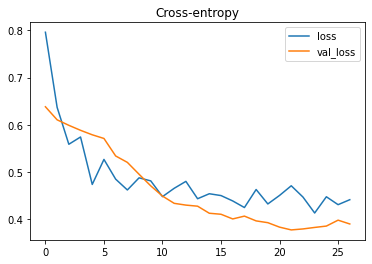

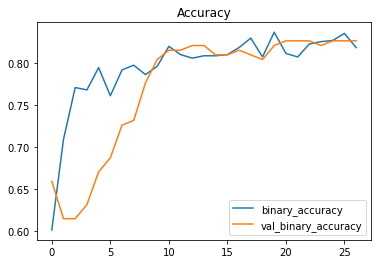

In [224]:
model = keras.Sequential([
    layers.BatchNormalization(input_shape = input_shape)
   ,layers.Dense(128,activation='relu')
    ,layers.BatchNormalization()
    ,layers.Dropout(0.3)
    ,layers.Dense(128,activation='relu')
    ,layers.BatchNormalization()
    ,layers.Dropout(0.3)    
    ,layers.Dense(128,activation='relu')
    ,layers.BatchNormalization()
    ,layers.Dropout(0.3)
    ,layers.Dense(128,activation='relu')
    ,layers.BatchNormalization()
    ,layers.Dropout(0.3)    
    ,layers.Dense(1,activation='sigmoid')
])

model.compile(
    optimizer="adam"
    ,loss="binary_crossentropy"
    ,metrics=["binary_accuracy"]
)

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True
)
history = model.fit(
    X_train
    ,y_train

    ,validation_data=(X_valid,y_valid)
    ,callbacks=[early_stopping]
    ,batch_size=50
    ,epochs=200
    ,verbose=0)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [227]:
preds2 = model.predict(X_test)
df = pd.DataFrame(columns=['PassengerId','Survived'])
df['PassengerId'] = X_test.index
df['Survived'] = (preds2>0.50)
df[['PassengerId','Survived']].to_csv('submission.csv', index=False)

TypeError: only size-1 arrays can be converted to Python scalars

In [15]:

randfor = RandomForestClassifier(n_estimators=300)

randfor.fit(X_train,y_train)

preds = randfor.predict(X_valid)

acc_random_forest = accuracy_score(preds, y_valid)
acc_random_forest


0.8435754189944135

In [16]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

randforopt = RandomForestClassifier()
#randfor_cv_classifier = GridSearchCV(randforopt, param_grid, cv=5,
#                                 scoring='accuracy', verbose=2)

#randfor_cv_classifier.fit(X_train, y_train)

#randfor_cv_classifier.best_estimator_.get_params()
#full_pred_randfor = randfor_cv_classifier.predict(X_valid)
#rf_acc_gridsearchCV = accuracy_score(full_pred_randfor, y_valid)
#print('accuracy_score :',rf_acc_gridsearchCV)


In [17]:
LGBM = lgb.LGBMClassifier()

param_grid = { 
    'n_estimators': [100, 300, 500,800,1500],
    'learning_rate': [0.001,0.01,0.1],
    'max_depth' : [4,5,6,7,8],
    'num_leaves' :[16,32,64,128,265],
    'boosting':['dart']
}

#lgbm_cv_classifier = GridSearchCV(LGBM, param_grid, cv=5,
#                                 scoring='accuracy', verbose=2)

#lgbm_cv_classifier.fit(X_train, y_train)

#lgbm_cv_classifier.best_estimator_.get_params()
#full_pred_lgbm = lgbm_cv_classifier.predict(X_valid)
#lgbm_acc_gridsearchCV = accuracy_score(full_pred_lgbm, y_valid)
#print('accuracy_score :',lgbm_acc_gridsearchCV)



#acc_lgbm = accuracy_score(full_pred_lgbm, y_valid)

#acc_lgbm

In [18]:
k_values = list(range(1, 20))
param_grid = {'n_neighbors': k_values}
knn = KNeighborsClassifier()
#full_cv_classifier = GridSearchCV(knn, param_grid, cv=5,
#                                 scoring='accuracy')

#full_cv_classifier.fit(X_train, y_train)

#full_cv_classifier.best_estimator_.get_params()
#full_pred = full_cv_classifier.predict(X_valid)
#knn_acc_gridsearchCV = accuracy_score(full_pred, y_valid)
#print('accuracy_score :',knn_acc_gridsearchCV)

In [19]:
rfc = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=42,
                                           n_jobs=-1,
                                           verbose=1) 
rfc.fit(X_train,y_train)

preds = rfc.predict(X_valid)

acc_random_forest = round(rfc.score(X_valid, y_valid) * 100, 2)
acc_random_forest


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 418 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 768 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1218 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 1750 out of 1750 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concur

85.47

In [20]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = y.copy()

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, X, y, cv  = cv_split,return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!

    #save MLA predictions - see section 6 for usage
    alg.fit(X, y)
    MLA_predict[MLA_name] = alg.predict(X)
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

[15:06:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:06:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:06:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:06:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
19,LinearDiscriminantAnalysis,"{'covariance_estimator': None, 'n_components':...",0.829588,0.828731,0.04518,0.0026
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.932584,0.823134,0.048329,0.079697
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.832397,0.822015,0.064703,0.537323
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.987828,0.820522,0.054942,0.107795
8,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.827715,0.820149,0.034247,0.00285
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.970787,0.811194,0.045936,0.018303
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.855805,0.811194,0.061557,0.0016
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.938577,0.809701,0.089832,0.076446
15,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.814232,0.809328,0.046546,0.05611
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.8603,0.808209,0.060531,0.05386


Text(0, 0.5, 'Algorithm')

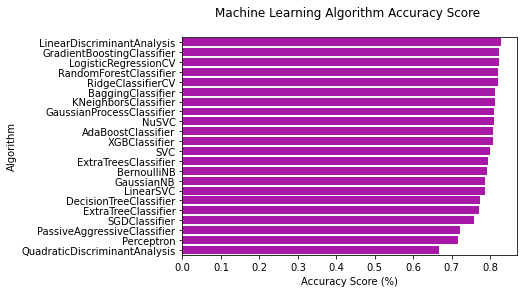

In [21]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [22]:
#base model
dtree = tree.DecisionTreeClassifier(random_state = 0)
base_results = model_selection.cross_validate(dtree, X, y, cv  = cv_split,return_train_score=True)
dtree.fit(X, y)

print('BEFORE DT Parameters: ', dtree.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
#print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)


#tune hyper-parameters: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              #'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
             }

#print(list(model_selection.ParameterGrid(param_grid)))

#choose best model with grid_search: #http://scikit-learn.org/stable/modules/grid_search.html#grid-search
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split,return_train_score=True)
tune_model.fit(X, y)

#print(tune_model.cv_results_.keys())
#print(tune_model.cv_results_['params'])
print('AFTER DT Parameters: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(tune_model.cv_results_['mean_test_score'])
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)


BEFORE DT Parameters:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'best'}
BEFORE DT Training w/bin score mean: 98.78
BEFORE DT Test w/bin score mean: 77.31
BEFORE DT Test w/bin score 3*std: +/- 6.09
----------
AFTER DT Parameters:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 0.05, 'min_samples_split': 2, 'random_state': 0}
AFTER DT Training w/bin score mean: 89.96
AFTER DT Test w/bin score mean: 87.37
AFTER DT Test w/bin score 3*std: +/- 6.73
----------


In [23]:
#base model
print('BEFORE DT RFE Training Shape Old: ', X.shape) 
print('BEFORE DT RFE Training Columns Old: ', X.columns.values)

print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)



#feature selection
dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy', cv = cv_split)
dtree_rfe.fit(X, y)

#transform x&y to reduced features and fit new model
#alternative: can use pipeline to reduce fit and transform steps: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
X_rfe = X.columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree, X[X_rfe], y, cv  = cv_split,return_train_score=True)

#print(dtree_rfe.grid_scores_)
print('AFTER DT RFE Training Shape New: ', X[X_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_rfe)

print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)


#tune rfe model
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split,return_train_score=True)
rfe_tune_model.fit(X[X_rfe], y)

#print(rfe_tune_model.cv_results_.keys())
#print(rfe_tune_model.cv_results_['params'])
print('AFTER DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
#print(rfe_tune_model.cv_results_['mean_train_score'])
print("AFTER DT RFE Tuned Training w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(rfe_tune_model.cv_results_['mean_test_score'])
print("AFTER DT RFE Tuned Test w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT RFE Training Shape Old:  (891, 19)
BEFORE DT RFE Training Columns Old:  ['Age' 'Fare' 'FamilySize' 'Sex_female' 'Sex_male' 'Pclass_1' 'Pclass_2'
 'Pclass_3' 'Embarked_Q' 'Embarked_S' 'Agegroup_0 to 15'
 'Agegroup_16 to 49' 'Agegroup_50 to 59' 'Title_Misc' 'Title_Miss'
 'Title_Mr' 'Title_Mrs' 'PC1' 'PC2']
BEFORE DT RFE Training w/bin score mean: 98.78
BEFORE DT RFE Test w/bin score mean: 77.31
BEFORE DT RFE Test w/bin score 3*std: +/- 6.09
----------
AFTER DT RFE Training Shape New:  (891, 14)
AFTER DT RFE Training Columns New:  ['Age' 'Fare' 'FamilySize' 'Pclass_1' 'Pclass_2' 'Pclass_3' 'Embarked_S'
 'Agegroup_0 to 15' 'Agegroup_16 to 49' 'Agegroup_50 to 59' 'Title_Misc'
 'Title_Miss' 'PC1' 'PC2']
AFTER DT RFE Training w/bin score mean: 98.78
AFTER DT RFE Test w/bin score mean: 77.46
AFTER DT RFE Test w/bin score 3*std: +/- 6.45
----------
AFTER DT RFE Tuned Parameters:  {'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 0.05, 'min_samples_spli

In [24]:
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    #Gaussian Processes: http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    ('lr', linear_model.LogisticRegressionCV()),
    
    #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', svm.SVC(probability=True)),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', XGBClassifier())

]


#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, X, y, cv  = cv_split,return_train_score=True)
vote_hard.fit(X, y)

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)


#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, X, y, cv  = cv_split,return_train_score=True)
vote_soft.fit(X, y)

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('-'*10)

[15:07:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:07:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:07:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:08:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [25]:
#WARNING: Running is very computational intensive and time expensive.
#Code is written for experimental/developmental purposes and not production ready!


#Hyperparameter Tune with GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]


grid_param = [
            [{
            #AdaBoostClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
            'n_estimators': grid_n_estimator, #default=50
            'learning_rate': grid_learn, #default=1
            #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
            'random_state': grid_seed
            }],
       
    
            [{
            #BaggingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
            'n_estimators': grid_n_estimator, #default=10
            'max_samples': grid_ratio, #default=1.0
            'random_state': grid_seed
             }],

    
            [{
            #ExtraTreesClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'random_state': grid_seed
             }],


            [{
            #GradientBoostingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
            #'loss': ['deviance', 'exponential'], #default=’deviance’
            'learning_rate': [.05], #default=0.1 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            'n_estimators': [300], #default=100 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
            #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
            'max_depth': grid_max_depth, #default=3   
            'random_state': grid_seed
             }],

    
            [{
            #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
            'random_state': grid_seed
             }],
    
            [{    
            #GaussianProcessClassifier
            'max_iter_predict': grid_n_estimator, #default: 100
            'random_state': grid_seed
            }],
        
    
            [{
            #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
            'fit_intercept': grid_bool, #default: True
            #'penalty': ['l1','l2'],
            'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
            'random_state': grid_seed
             }],
            
    
            [{
            #BernoulliNB - http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB
            'alpha': grid_ratio, #default: 1.0
             }],
    
    
            #GaussianNB - 
            [{}],
    
            [{
            #KNeighborsClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
            'n_neighbors': [1,2,3,4,5,6,7], #default: 5
            'weights': ['uniform', 'distance'], #default = ‘uniform’
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
            }],
            
    
            [{
            #SVC - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
            #http://blog.hackerearth.com/simple-tutorial-svm-parameter-tuning-python-r
            #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'C': [1,2,3,4,5], #default=1.0
            'gamma': grid_ratio, #edfault: auto
            'decision_function_shape': ['ovo', 'ovr'], #default:ovr
            'probability': [True],
            'random_state': grid_seed
             }],

    
            [{
            #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
            'learning_rate': grid_learn, #default: .3
            'max_depth': [1,2,4,6,8,10], #default 2
            'n_estimators': grid_n_estimator, 
            'seed': grid_seed  
             }]   
        ]



start_total = time.perf_counter() #https://docs.python.org/3/library/time.html#time.perf_counter
for clf, param in zip (vote_est, grid_param): #https://docs.python.org/3/library/functions.html#zip

    #print(clf[1]) #vote_est is a list of tuples, index 0 is the name and index 1 is the algorithm
    #print(param)
    
    
    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(X, y)
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param) 


run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

KeyboardInterrupt: 

In [ ]:
#Hard Vote or majority rules w/Tuned Hyperparameters
grid_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard, X, y, cv  = cv_split,return_train_score=True)
grid_hard.fit(X, y)

print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_hard_cv['train_score'].mean()*100)) 
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_hard_cv['test_score'].std()*100*3))
print('-'*10)

#Soft Vote or weighted probabilities w/Tuned Hyperparameters
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft, X, y, cv  = cv_split,return_train_score=True)
grid_soft.fit(X, y)

print("Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100)) 
print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_soft_cv['test_score'].std()*100*3))
print('-'*10)

In [ ]:

GBC = ensemble.GradientBoostingClassifier()

GBC.fit(X,y)


In [ ]:
preds2 = GBC.predict(X_test)
df = pd.DataFrame(columns=['PassengerId','Survived'])
df['PassengerId'] = X_test.index
df['Survived'] = preds2
df[['PassengerId','Survived']].to_csv('submission.csv', index=False)